In [1]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy


Setup the pandas dataframe

In [2]:
os.getcwd()

base_dir = os.path.join("..", "data", "1v1_tournament_logs")

tournament_path = os.path.join(base_dir, "all_games_log.csv")

df = pd.read_csv(tournament_path)

print("Number of rows:", len(df))
print("Columns:", df.columns)

if "player_1_name" not in df.columns or "player_2_name" not in df.columns:
    df["player_1_name"] = df["bot1"]
    df["player_2_name"] = df["bot2"]
    df.loc[df["game_id"].str.contains("_g[2-4][0-9]{2}$"), ["player_1_name", "player_2_name"]] = \
        df.loc[df["game_id"].str.contains("_g[2-4][0-9]{2}$"), ["bot2", "bot1"]].values

df.head()


Number of rows: 97661
Columns: Index(['round_id', 'camel_c_0_location', 'camel_c_0_stack_location',
       'camel_c_0_yet_to_move', 'camel_c_1_location',
       'camel_c_1_stack_location', 'camel_c_1_yet_to_move',
       'camel_c_2_location', 'camel_c_2_stack_location',
       'camel_c_2_yet_to_move', 'camel_c_3_location',
       'camel_c_3_stack_location', 'camel_c_3_yet_to_move',
       'camel_c_4_location', 'camel_c_4_stack_location',
       'camel_c_4_yet_to_move', 'player_0_coins', 'player_1_coins',
       'active_player', 'action_type', 'camel', 'bet_type', 'trap_type',
       'trap_location', 'player_1_trap_location', 'player_1_trap_type',
       'distance', 'player_0_trap_location', 'player_0_trap_type', 'game_id',
       'bot1', 'bot2', 'player_1_name', 'player_2_name', 'player_1_final',
       'player_2_final', 'winner'],
      dtype='object')


,round_id,camel_c_0_location,camel_c_0_stack_location,camel_c_0_yet_to_move,camel_c_1_location,camel_c_1_stack_location,camel_c_1_yet_to_move,camel_c_2_location,camel_c_2_stack_location,camel_c_2_yet_to_move,...,player_0_trap_location,player_0_trap_type,game_id,bot1,bot2,player_1_name,player_2_name,player_1_final,player_2_final,winner
0,0,1,2,True,1,1,True,2,0,True,...,NaN,NaN,RandomAgent_vs_MCTSAgent_g0,RandomAgent,MCTSAgent,RandomAgent,MCTSAgent,15,27,MCTSAgent
1,1,1,2,True,1,1,True,2,0,True,...,NaN,NaN,RandomAgent_vs_MCTSAgent_g0,RandomAgent,MCTSAgent,RandomAgent,MCTSAgent,15,27,MCTSAgent
2,2,1,2,True,1,1,True,2,0,True,...,NaN,NaN,RandomAgent_vs_MCTSAgent_g0,RandomAgent,MCTSAgent,RandomAgent,MCTSAgent,15,27,MCTSAgent
3,3,1,2,True,1,1,True,2,0,True,...,NaN,NaN,RandomAgent_vs_MCTSAgent_g0,RandomAgent,MCTSAgent,RandomAgent,MCTSAgent,15,27,MCTSAgent
4,4,1,2,True,1,1,True,2,0,True,...,NaN,NaN,RandomAgent_vs_MCTSAgent_g0,RandomAgent,MCTSAgent,RandomAgent,MCTSAgent,15,27,MCTSAgent


Greedy bot losses!

In [3]:
last_rows = df.sort_values(by=["round_id"]).groupby("game_id").tail(1)

greedy_games = last_rows[
    (last_rows["player_1_name"] == "GreedyAgent") | (last_rows["player_2_name"] == "GreedyAgent")
]

greedy_losses = greedy_games[greedy_games["winner"] != "GreedyAgent"]

greedy_losses = greedy_losses.reset_index(drop=True)

greedy_losses[["game_id", "player_1_name", "player_2_name", "player_1_final", "player_2_final", "winner"]].head(10)


,game_id,player_1_name,player_2_name,player_1_final,player_2_final,winner
0,GameBetAgent_vs_GreedyAgent_g42,GreedyAgent,GameBetAgent,26,28,GameBetAgent
1,GameBetAgent_vs_GreedyAgent_g27,GreedyAgent,GameBetAgent,33,34,GameBetAgent
2,RoundBetAgent_vs_GreedyAgent_g19,RoundBetAgent,GreedyAgent,17,17,tie
3,RoundBetAgent_vs_GreedyAgent_g39,GreedyAgent,RoundBetAgent,27,33,RoundBetAgent
4,RoundBetAgent_vs_GreedyAgent_g32,GreedyAgent,RoundBetAgent,38,38,tie
5,RoundBetAgent_vs_GreedyAgent_g29,GreedyAgent,RoundBetAgent,37,37,tie
6,MCTSAgent_vs_GreedyAgent_g44,GreedyAgent,MCTSAgent,32,36,MCTSAgent
7,MCTSAgent_vs_GreedyAgent_g49,GreedyAgent,MCTSAgent,27,29,MCTSAgent


Average Move Type

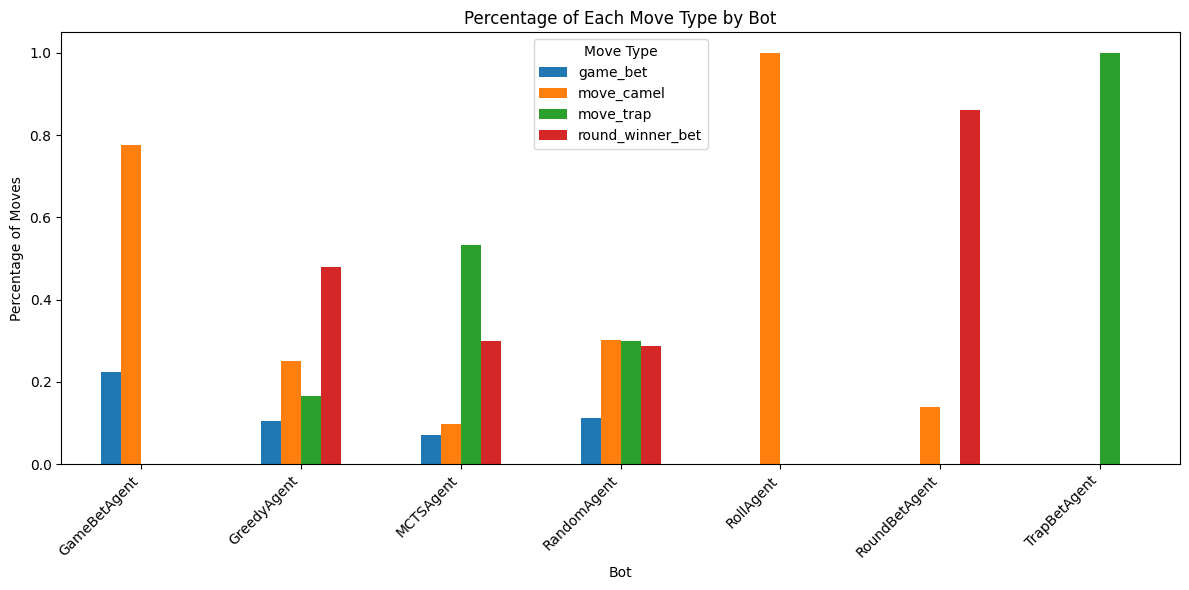

In [4]:
df["acting_player"] = df.apply(
    lambda row: row["player_1_name"] if row["active_player"] == 0 else row["player_2_name"], axis=1
)

move_counts = df.groupby(["acting_player", "action_type"]).size().unstack(fill_value=0)

move_percentages = move_counts.div(move_counts.sum(axis=1), axis=0)

move_percentages.plot(kind="bar", stacked=False, figsize=(12, 6))
plt.title("Percentage of Each Move Type by Bot")
plt.ylabel("Percentage of Moves")
plt.xlabel("Bot")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Move Type")
plt.tight_layout()
plt.show()


Average Coins + Average Score Differences

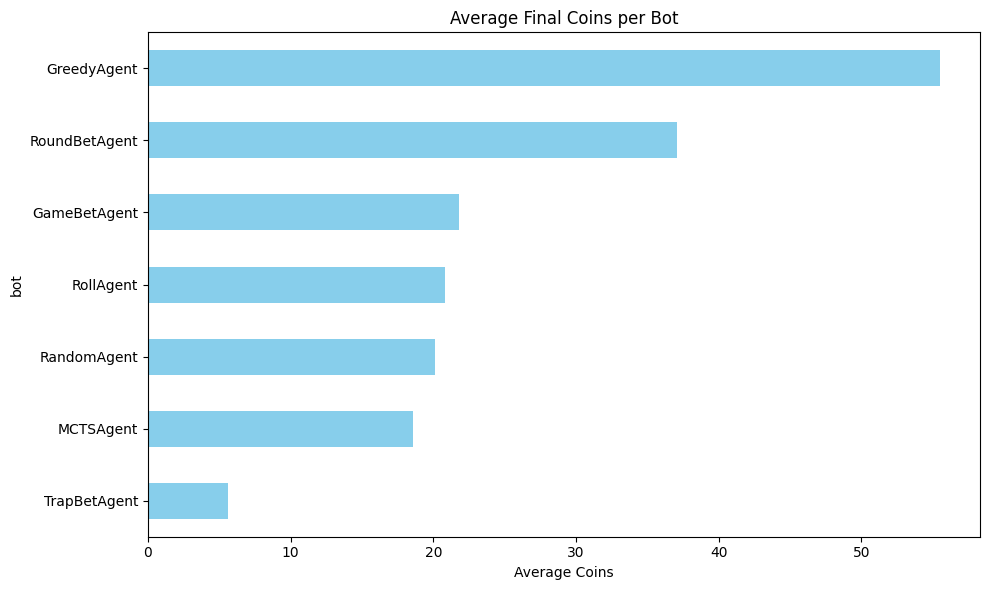

In [5]:
# 1. Get final state per game
final_rows = df.sort_values("round_id").groupby("game_id").tail(1)

# 2. Average coins per bot (whether player 1 or 2)
coin_data = []

for _, row in final_rows.iterrows():
    coin_data.append((row["player_1_name"], row["player_1_final"]))
    coin_data.append((row["player_2_name"], row["player_2_final"]))

coin_df = pd.DataFrame(coin_data, columns=["bot", "coins"])
avg_coins = coin_df.groupby("bot")["coins"].mean().sort_values()

# Plot: Average coins per bot
avg_coins.plot(kind="barh", figsize=(10, 6), color="skyblue")
plt.title("Average Final Coins per Bot")
plt.xlabel("Average Coins")
plt.tight_layout()
plt.show()


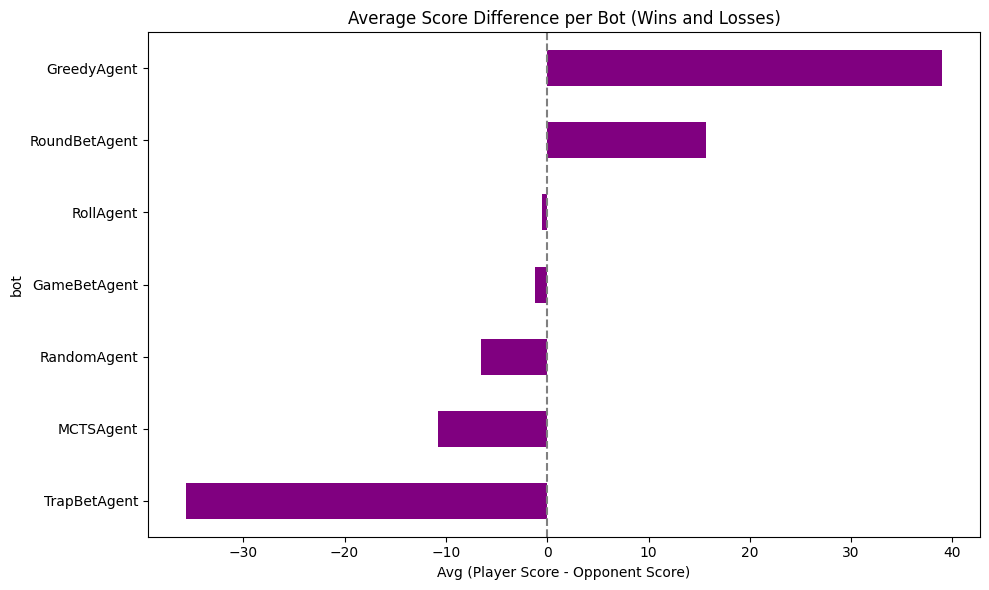

In [6]:
final_rows = df.sort_values("round_id").groupby("game_id").tail(1)

diff_data = []

for _, row in final_rows.iterrows():
    diff_p1 = row["player_1_final"] - row["player_2_final"]
    diff_p2 = row["player_2_final"] - row["player_1_final"]
    diff_data.append((row["player_1_name"], diff_p1))
    diff_data.append((row["player_2_name"], diff_p2))

diff_df = pd.DataFrame(diff_data, columns=["bot", "score_diff"])
avg_diff = diff_df.groupby("bot")["score_diff"].mean().sort_values()

avg_diff.plot(kind="barh", figsize=(10, 6), color="purple")
plt.title("Average Score Difference per Bot (Wins and Losses)")
plt.xlabel("Avg (Player Score - Opponent Score)")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


Margin of Victory in only Wins

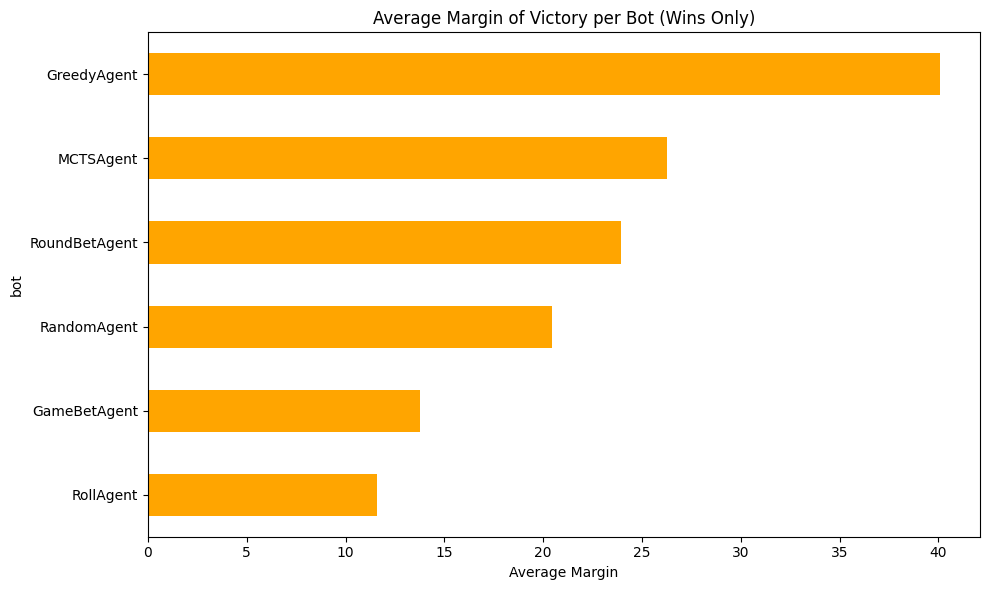

In [7]:
margin_data = []

for _, row in final_rows.iterrows():
    if row["winner"] == row["player_1_name"]:
        margin = row["player_1_final"] - row["player_2_final"]
        margin_data.append((row["player_1_name"], margin))
    elif row["winner"] == row["player_2_name"]:
        margin = row["player_2_final"] - row["player_1_final"]
        margin_data.append((row["player_2_name"], margin))

margin_df = pd.DataFrame(margin_data, columns=["bot", "margin"])
avg_margin = margin_df.groupby("bot")["margin"].mean().sort_values()

avg_margin.plot(kind="barh", figsize=(10, 6), color="orange")
plt.title("Average Margin of Victory per Bot (Wins Only)")
plt.xlabel("Average Margin")
plt.tight_layout()
plt.show()


Win Rate by Opponent (Heatmap)

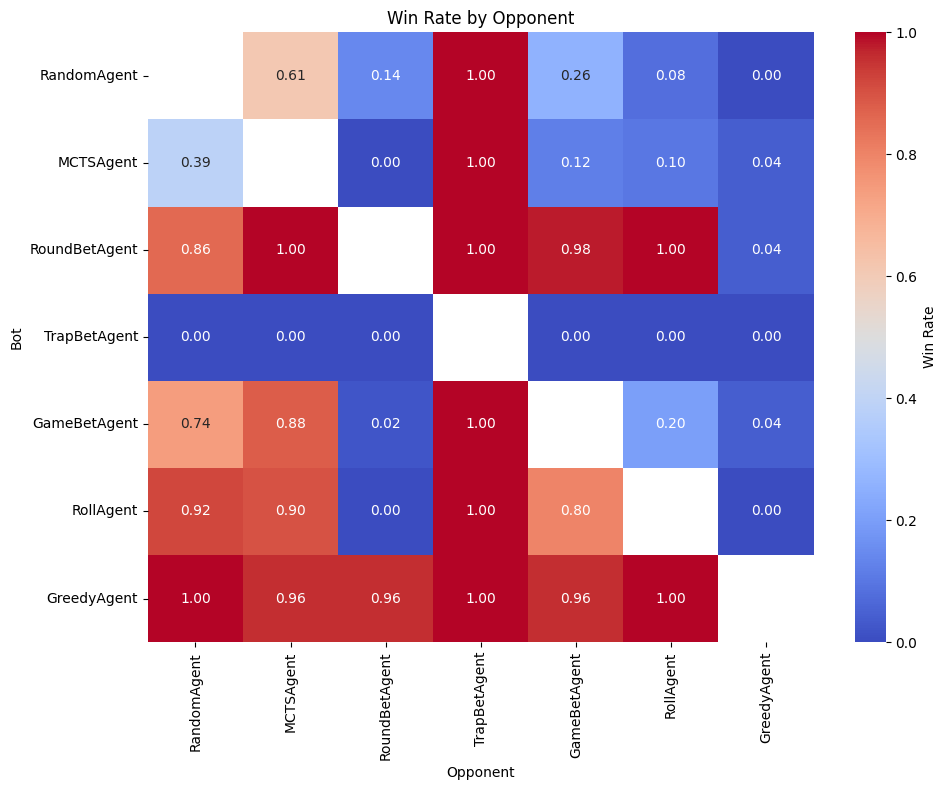

In [8]:
base_dir = os.path.join("..", "data", "1v1_tournament_logs")

wins_path = os.path.join(base_dir, "head_to_head_win_matrix.csv")

win_matrix = pd.read_csv(wins_path, index_col=0)

win_rate_matrix = win_matrix.div(win_matrix + win_matrix.T)

plt.figure(figsize=(10, 8))
sns.heatmap(win_rate_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Win Rate"})
plt.title("Win Rate by Opponent")
plt.xlabel("Opponent")
plt.ylabel("Bot")
plt.tight_layout()
plt.show()


Wins by Position (Bar Chart)

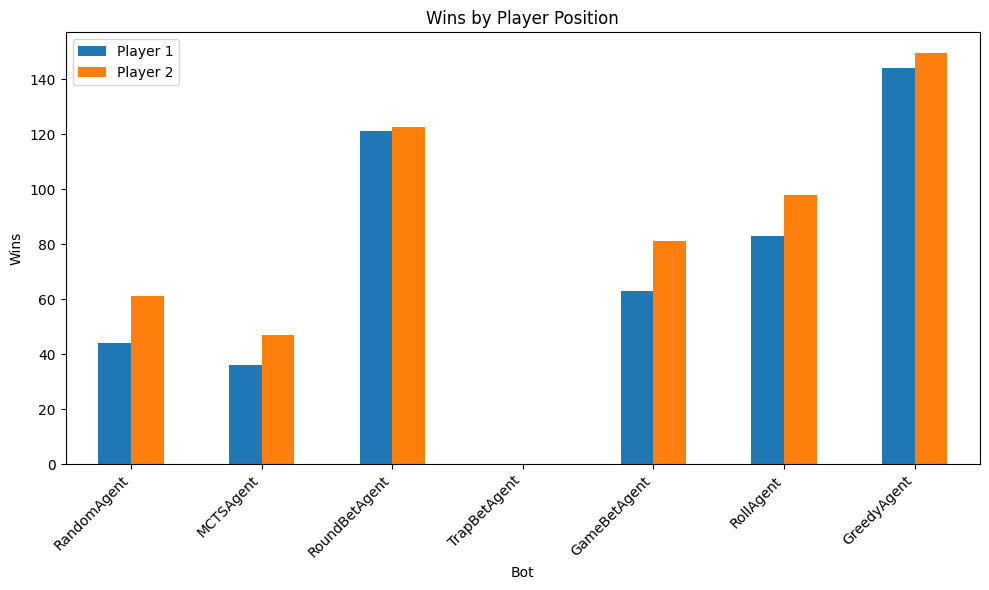

In [9]:
base_dir = os.path.join("..", "data", "1v1_tournament_logs")

player_path = os.path.join(base_dir, "player_position_wins.csv")

pos_df = pd.read_csv(player_path)

pos_df.set_index("bot")[["wins_as_player_1", "wins_as_player_2"]].plot(
    kind="bar", figsize=(10, 6), color=["#1f77b4", "#ff7f0e"]
)
plt.title("Wins by Player Position")
plt.ylabel("Wins")
plt.xlabel("Bot")
plt.xticks(rotation=45, ha='right')
plt.legend(["Player 1", "Player 2"])
plt.tight_layout()
plt.show()


Action Type Over Time

<Figure size 1000x500 with 0 Axes>

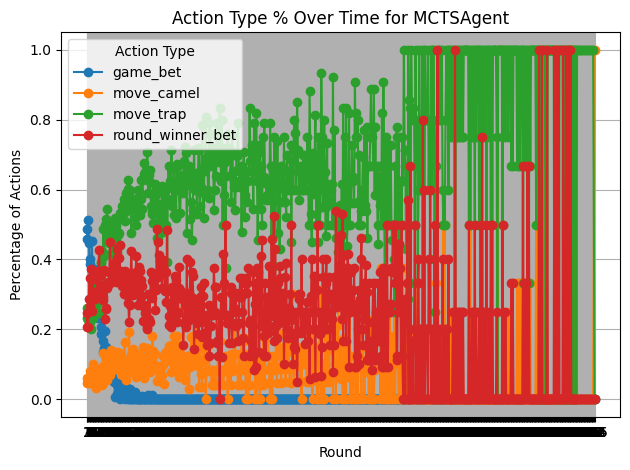

<Figure size 1000x500 with 0 Axes>

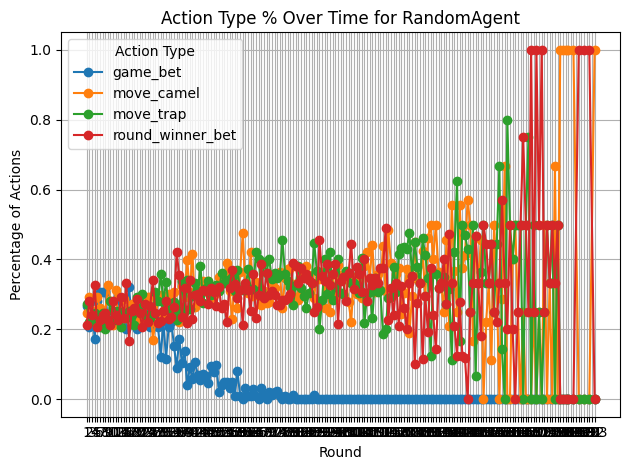

<Figure size 1000x500 with 0 Axes>

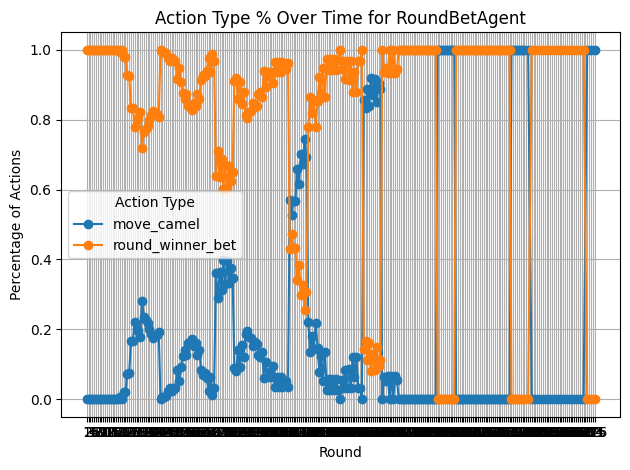

<Figure size 1000x500 with 0 Axes>

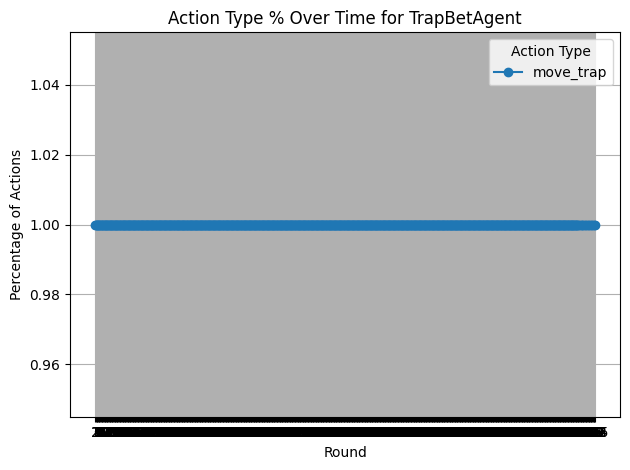

<Figure size 1000x500 with 0 Axes>

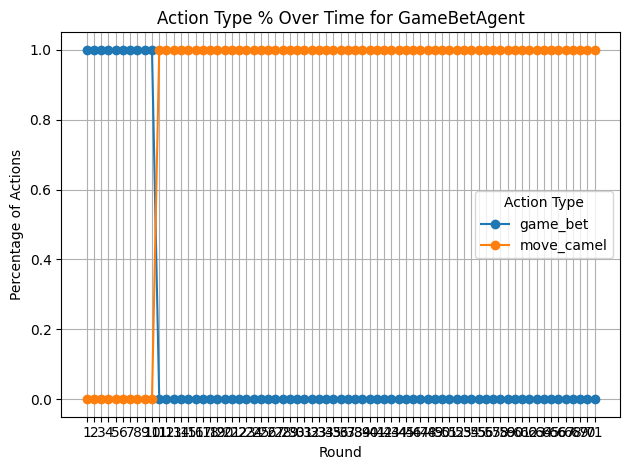

<Figure size 1000x500 with 0 Axes>

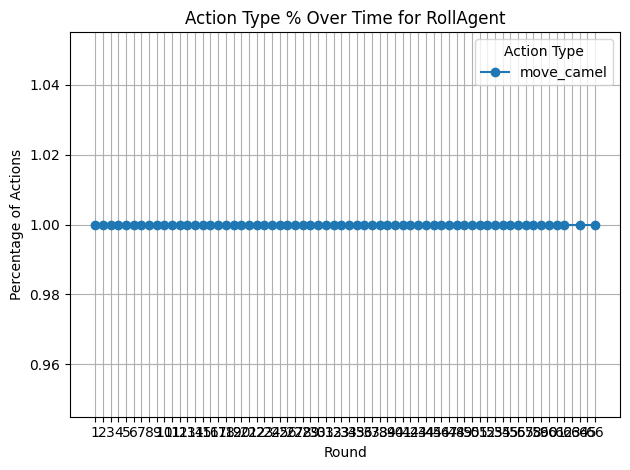

<Figure size 1000x500 with 0 Axes>

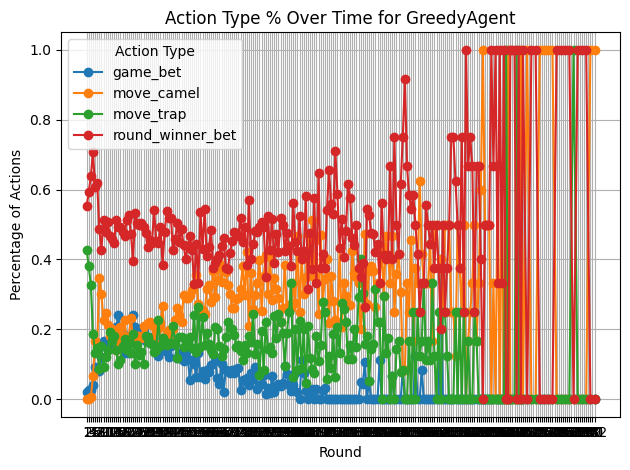

In [10]:
base_dir = os.path.join("..", "data", "1v1_tournament_logs")
all_games_path = os.path.join(base_dir, "all_games_log.csv")
df = pd.read_csv(all_games_path)

if "acting_player" not in df.columns:
    df["acting_player"] = df.apply(
        lambda row: row["player_1_name"] if row["active_player"] == 0 else row["player_2_name"], axis=1
    )

action_over_time = (
    df.groupby(["round_id", "acting_player", "action_type"])
    .size()
    .reset_index(name="count")
)

total_actions_per_round_bot = action_over_time.groupby(["round_id", "acting_player"])["count"].transform("sum")
action_over_time["percentage"] = action_over_time["count"] / total_actions_per_round_bot

bots = df["acting_player"].unique()
for bot in bots:
    subset = action_over_time[action_over_time["acting_player"] == bot]
    pivot = subset.pivot(index="round_id", columns="action_type", values="percentage").fillna(0)

    plt.figure(figsize=(10, 5))
    pivot.plot(kind="line", marker="o", title=f"Action Type % Over Time for {bot}")
    plt.ylabel("Percentage of Actions")
    plt.xlabel("Round")
    plt.xticks(range(pivot.index.min(), pivot.index.max() + 1))
    plt.legend(title="Action Type")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Action Diversity Score (Entropy)

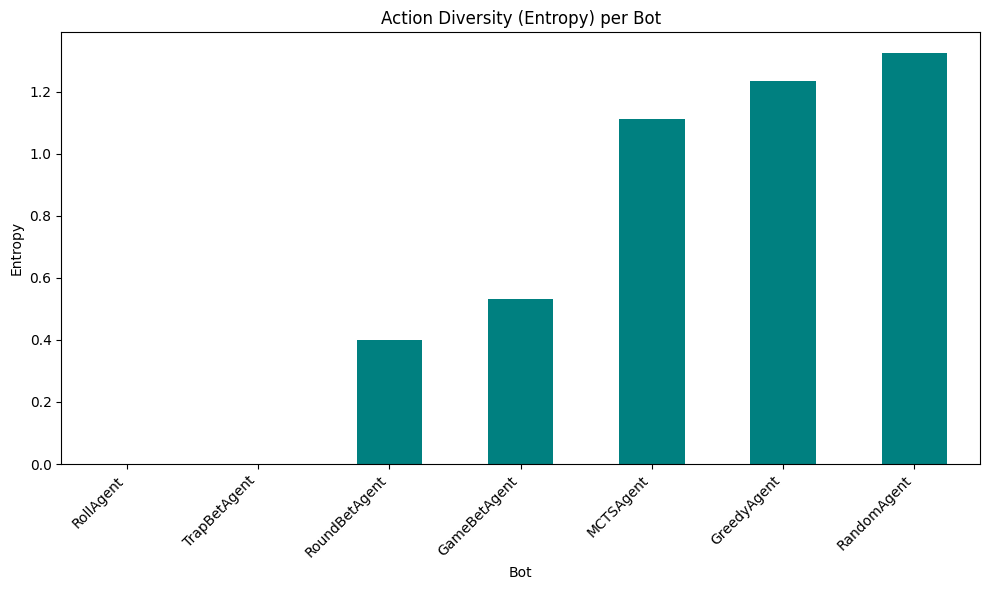

In [11]:
action_counts = df.groupby(["acting_player", "action_type"]).size().unstack(fill_value=0)

action_entropy = action_counts.apply(lambda row: entropy(row), axis=1).sort_values()

plt.figure(figsize=(10, 6))
action_entropy.plot(kind="bar", color="teal")
plt.title("Action Diversity (Entropy) per Bot")
plt.ylabel("Entropy")
plt.xlabel("Bot")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


EV per Action Type

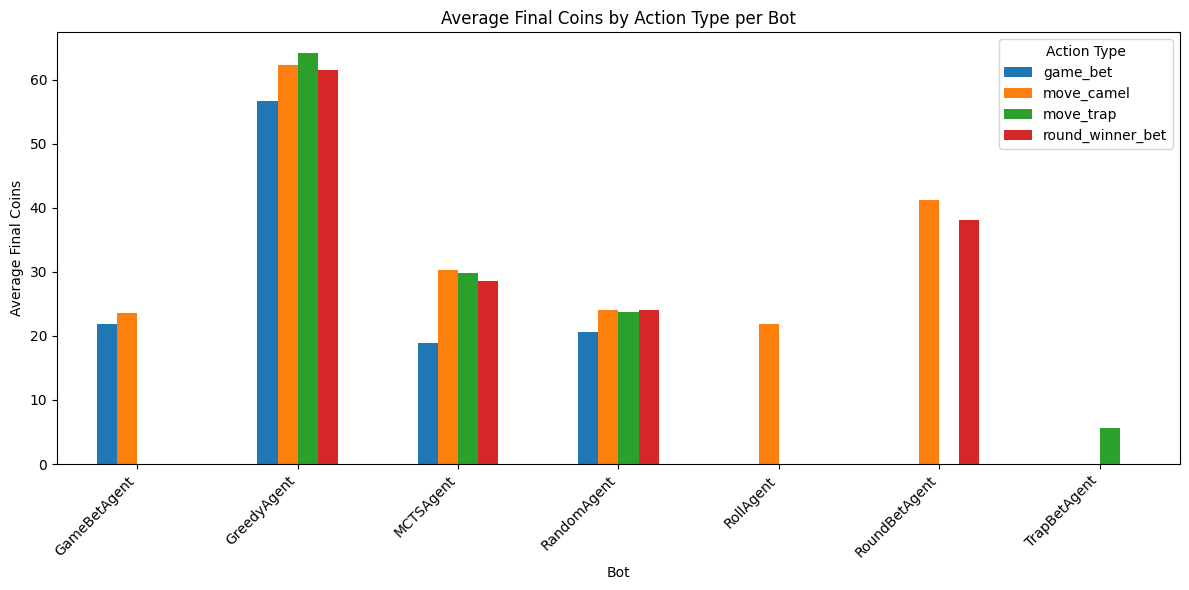

In [12]:
# Join the round-level data (df) with final coin values
finals = df.sort_values("round_id").groupby("game_id").tail(1)
finals_lookup = finals.set_index("game_id")[["player_1_name", "player_1_final", "player_2_name", "player_2_final"]]

# Match final coin value to each row in df
def get_final_coins(row):
    game = finals_lookup.loc[row["game_id"]]
    if row["acting_player"] == game["player_1_name"]:
        return game["player_1_final"]
    elif row["acting_player"] == game["player_2_name"]:
        return game["player_2_final"]
    else:
        return None

df["final_coins"] = df.apply(get_final_coins, axis=1)

# Now compute EV per action type per bot
ev_by_action = df.groupby(["acting_player", "action_type"])["final_coins"].mean().unstack()

# Plot
ev_by_action.plot(kind="bar", figsize=(12, 6))
plt.title("Average Final Coins by Action Type per Bot")
plt.ylabel("Average Final Coins")
plt.xlabel("Bot")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Action Type")
plt.tight_layout()
plt.show()


Game Duration by Winner

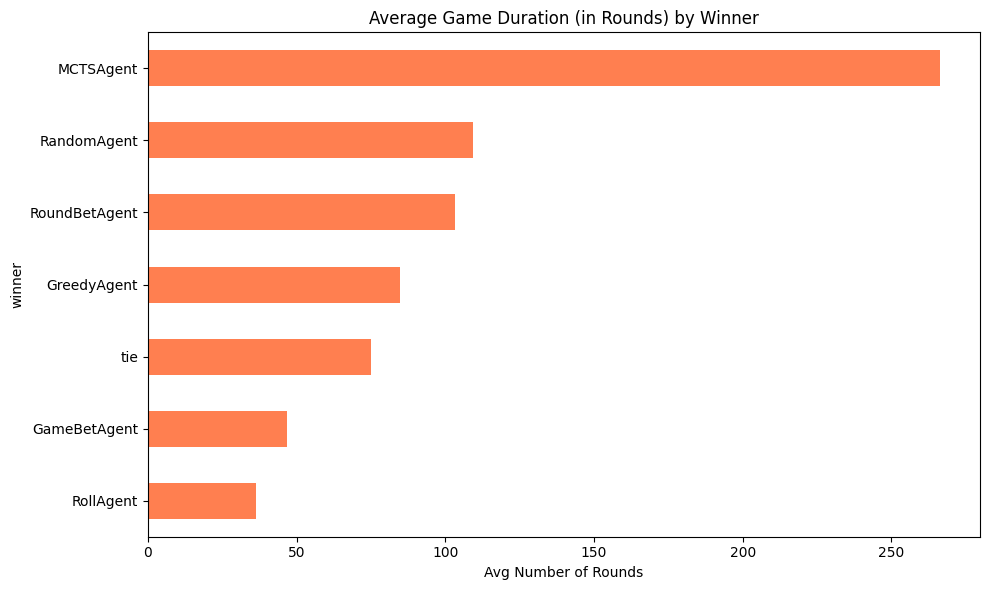

In [13]:

final_rows = df.sort_values("round_id").groupby("game_id").tail(1)

rounds_by_game = df.groupby("game_id")["round_id"].max().reset_index()
rounds_by_game.columns = ["game_id", "num_rounds"]

rounds_by_game = rounds_by_game.merge(final_rows[["game_id", "winner"]], on="game_id")

duration_stats = rounds_by_game.groupby("winner")["num_rounds"].mean().sort_values()

duration_stats.plot(kind="barh", figsize=(10, 6), color="coral")
plt.title("Average Game Duration (in Rounds) by Winner")
plt.xlabel("Avg Number of Rounds")
plt.tight_layout()
plt.show()


comeback wins

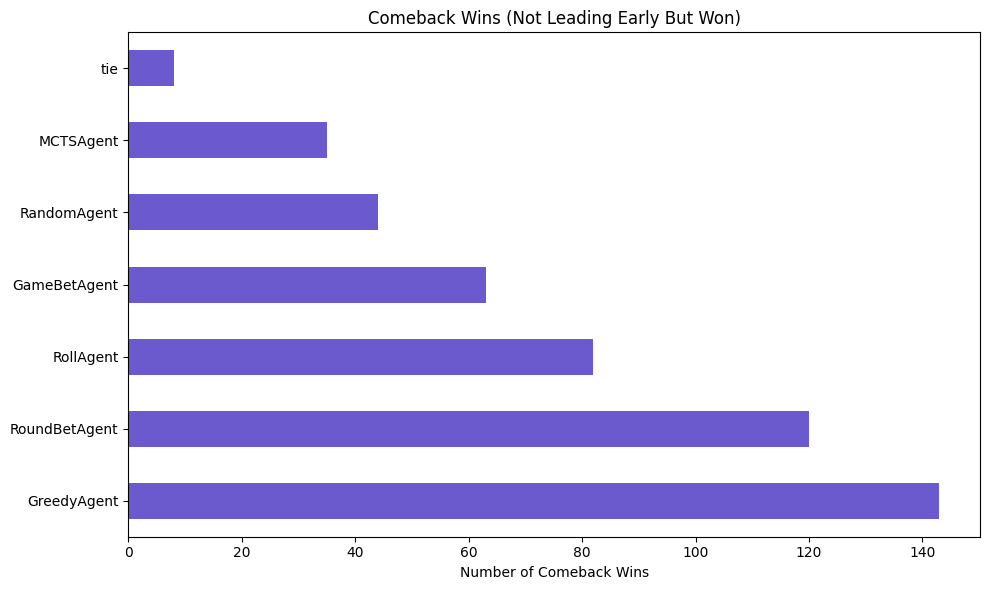

In [14]:
early_snapshots = df[df["round_id"].isin(range(30))]
early_scores = early_snapshots.sort_values("round_id").groupby("game_id").first()

finals = df.sort_values("round_id").groupby("game_id").tail(1)

comeback_wins = []

for game_id, early in early_scores.iterrows():
    final = finals[finals["game_id"] == game_id].iloc[0]
    
    early_leader = early["player_1_name"] if early["player_0_coins"] > early["player_1_coins"] else early["player_2_name"]
    
    if final["winner"] != early_leader:
        comeback_wins.append(final["winner"])

comeback_df = pd.Series(comeback_wins).value_counts()

comeback_df.plot(kind="barh", figsize=(10, 6), color="slateblue")
plt.title("Comeback Wins (Not Leading Early But Won)")
plt.xlabel("Number of Comeback Wins")
plt.tight_layout()
plt.show()


Average Coin Delta vs Opponent

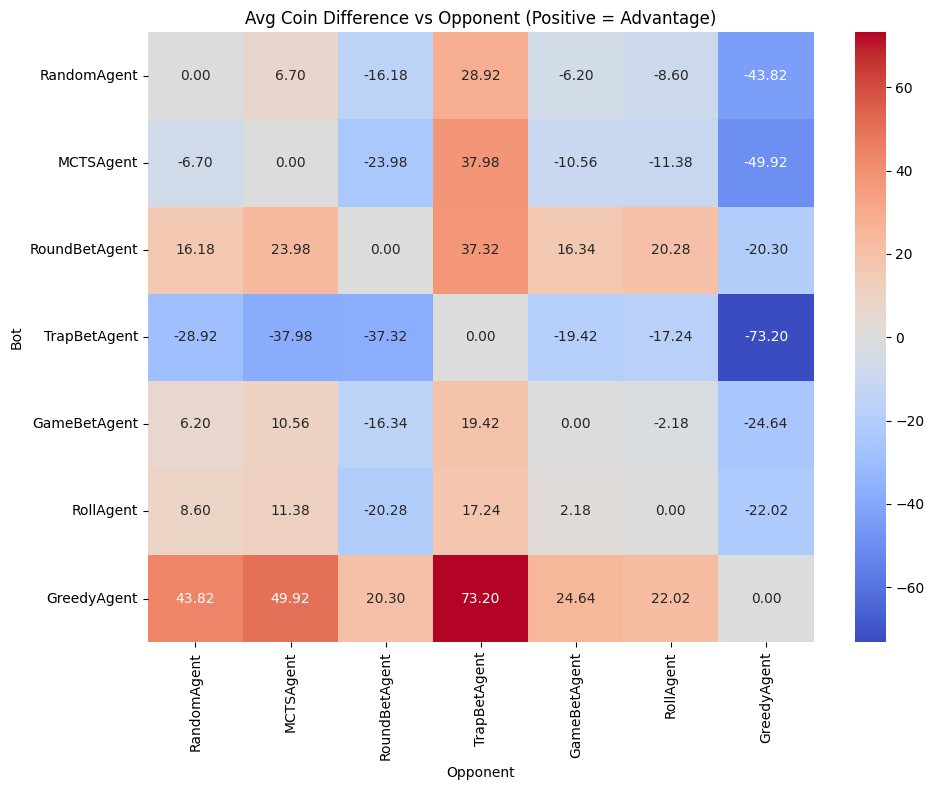

In [15]:
bot_names = df["player_1_name"].unique()
coin_diff_matrix = defaultdict(lambda: defaultdict(list))

for _, row in finals.iterrows():
    p1, p2 = row["player_1_name"], row["player_2_name"]
    c1, c2 = row["player_1_final"], row["player_2_final"]
    
    coin_diff_matrix[p1][p2].append(c1 - c2)
    coin_diff_matrix[p2][p1].append(c2 - c1)

# Average them
coin_diff_avg = {
    bot1: {
        bot2: np.mean(coin_diff_matrix[bot1][bot2]) if coin_diff_matrix[bot1][bot2] else 0
        for bot2 in bot_names
    }
    for bot1 in bot_names
}

coin_delta_df = pd.DataFrame(coin_diff_avg).T

plt.figure(figsize=(10, 8))
sns.heatmap(coin_delta_df, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Avg Coin Difference vs Opponent (Positive = Advantage)")
plt.xlabel("Opponent")
plt.ylabel("Bot")
plt.tight_layout()
plt.show()


In [16]:
def compute_summary_stats(log_path="all_games_log.csv", initial_elo=1000, k=32):
    base_dir = os.path.join("..", "data", "1v1_tournament_logs")
    all_games_path = os.path.join(base_dir, log_path)
    df = pd.read_csv(all_games_path)
    final_states = df.drop_duplicates(subset=["game_id"], keep="last").copy()
    bots = pd.unique(final_states[["player_1_name", "player_2_name"]].values.ravel())

    stats = []

    for bot in bots:
        games_as_p1 = final_states[final_states["player_1_name"] == bot]
        games_as_p2 = final_states[final_states["player_2_name"] == bot]
        all_games = pd.concat([games_as_p1.assign(role="p1"), games_as_p2.assign(role="p2")])

        all_games["final_score"] = all_games.apply(
            lambda row: row["player_1_final"] if row["player_1_name"] == bot else row["player_2_final"], axis=1
        )
        all_games["opponent_score"] = all_games.apply(
            lambda row: row["player_2_final"] if row["player_1_name"] == bot else row["player_1_final"], axis=1
        )

        win_rate = np.mean(all_games["winner"] == bot)
        avg_score = np.mean(all_games["final_score"])
        var_score = np.var(all_games["final_score"])
        min_score = np.min(all_games["final_score"])
        max_score = np.max(all_games["final_score"])
        avg_margin = np.mean(all_games["final_score"] - all_games["opponent_score"])
        avg_game_length = df[df["game_id"].isin(all_games["game_id"])].groupby("game_id").size().mean()

        stats.append({
            "bot": bot,
            "games_played": len(all_games),
            "win_rate": win_rate,
            "avg_score": avg_score,
            "score_variance": var_score,
            "min_score": min_score,
            "max_score": max_score,
            "avg_win_margin": avg_margin,
            "avg_game_length": avg_game_length
        })

    summary_df = pd.DataFrame(stats)

    # ELO calculation
    elo_ratings = defaultdict(lambda: initial_elo)
    game_results = final_states[["player_1_name", "player_2_name", "winner"]]

    for _, row in game_results.iterrows():
        p1 = row["player_1_name"]
        p2 = row["player_2_name"]
        winner = row["winner"]

        r1 = elo_ratings[p1]
        r2 = elo_ratings[p2]

        expected_1 = 1 / (1 + 10 ** ((r2 - r1) / 400))
        expected_2 = 1 - expected_1

        score_1 = 1 if winner == p1 else 0
        score_2 = 1 if winner == p2 else 0

        elo_ratings[p1] += k * (score_1 - expected_1)
        elo_ratings[p2] += k * (score_2 - expected_2)

    summary_df["elo"] = summary_df["bot"].map(elo_ratings)
    summary_df = summary_df.sort_values(by="elo", ascending=False).reset_index(drop=True)
    return summary_df

compute_summary_stats(log_path="all_games_log.csv", initial_elo=1000, k=32)


,bot,games_played,win_rate,avg_score,score_variance,min_score,max_score,avg_win_margin,avg_game_length,elo
0,GreedyAgent,300,0.973333,55.540000,288.981733,17,109,38.983333,85.490000,1642.937528
1,RoundBetAgent,300,0.803333,37.103333,125.679322,10,63,15.633333,99.833333,1186.944304
2,RollAgent,300,0.600000,20.816667,21.003056,10,35,-0.483333,38.280000,1059.645189
3,GameBetAgent,300,0.480000,21.806667,56.795956,4,41,-1.163333,45.453333,1030.103840
4,MCTSAgent,300,0.273333,18.606667,210.845289,-8,64,-10.760000,136.746667,793.300546
5,RandomAgent,300,0.343333,20.090000,138.321900,-5,65,-6.530000,85.530000,648.019313
6,TrapBetAgent,300,0.000000,5.580000,3.890267,2,12,-35.680000,159.740000,383.049280
